In [6]:
# Import relevant libraries and modules
# Data analysis
import pandas as pd
import sklearn as sk
import seaborn as sns
import numpy as np
import csv
import numpy as np
import pandas as pd
import datetime
from sklearn.model_selection import train_test_split
import sklearn.linear_model as lm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
# Import retail store dataset
retail_ds = pd.read_csv('summer_internship_takehome.csv')
retail_ds.head()

,Location number,Month,State,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned
0,1,1,TX,48628171.02,9218156.69,24278189.23,365880,4452,False
1,1,2,TX,48107179.24,10587747.35,25116844.41,365880,4452,False
2,1,3,TX,64352278.29,10193873.77,33703499.83,365880,4452,False
3,1,4,TX,45943677.96,8764165.00,24037719.47,365880,4452,False
4,1,5,TX,32761434.98,8022116.43,16432119.18,365880,4452,False


# I. Summary statistics and plots

Mean:  0.2486322925670752
Median:  0.26184928404393765


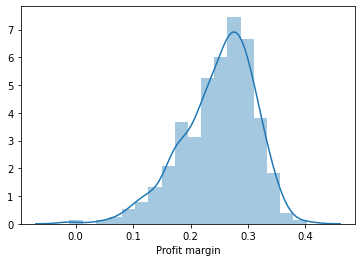

In [97]:
# Group rows by location
retail_grouped = retail_ds.groupby('Location number').sum().drop(columns={'Month', 'Number of products', 'Owned'})

# Add profit margin column
retail_grouped['Profit margin'] = (retail_grouped['Gross revenue'] - 
                                   retail_grouped['Fixed cost'] - 
                                   retail_grouped['Variable cost'] - 
                                   retail_grouped['Rental cost']) / retail_grouped['Gross revenue']

# Calculate mean and median annual profit margin
print("Mean: ", np.average(retail_grouped['Profit margin']))
print("Median: ", np.median(retail_grouped['Profit margin']))

# Visualize annual profit margin distribution
sns.distplot(retail_grouped['Profit margin']);




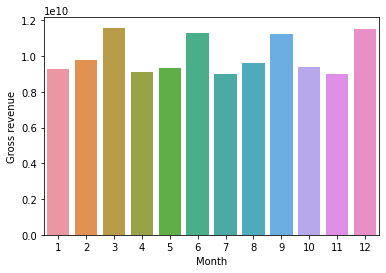

In [104]:
retail_monthly = retail_ds.groupby('Month').sum().drop(columns={'Location number', 'Fixed cost', 'Variable cost', 'Rental cost', 'Number of products', 'Owned'})
sns.barplot(x=retail_monthly.index, y=retail_monthly['Gross revenue']);

In [121]:
#[sum(retail_monthly.iloc[i:i+3]) for i in [0,3,6,9]]
sum(retail_monthly.iloc[0:0+3])

TypeError: unsupported operand type(s) for +: 'int' and 'str'

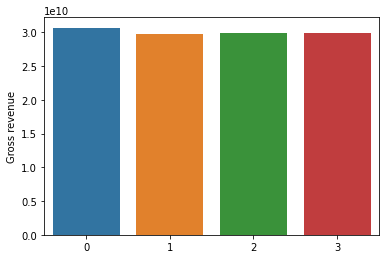

In [123]:
retail_quarterly = pd.DataFrame(
    data = {'Gross revenue' : [sum(retail_monthly.iloc[i:i+3, 0]) for i in [0,3,6,9]]}, columns=['Gross revenue']
)
sns.barplot(x=retail_quarterly.index, y=retail_quarterly['Gross revenue']);

# II. Cleaning the data

# III. Quantify drivers of success